1. Difference Between SVM Kernels

The main difference between SVM kernels lies in how they transform the data to separate classes:

Linear Kernel → Finds a straight-line (or hyperplane) boundary. Best for linearly separable data, fast, and interpretable.

Polynomial Kernel → Uses polynomial combinations of features to create curved boundaries. Useful when feature interactions matter, but higher degrees can overfit.

RBF (Radial Basis Function) Kernel → Uses Gaussian functions to create flexible, non-linear boundaries. Very powerful for complex datasets but requires careful parameter tuning.

2. When to Use Each Kernel

Linear kernel → When the dataset is high-dimensional but approximately linearly separable (e.g., text classification).

Polynomial kernel → When interactions between features may be important.

RBF kernel → Default choice for non-linear problems; suitable when class boundaries are complex, such as in fraud detection.

In [8]:
import pandas as pd

df=pd.read_csv('fraud.csv', index_col = 0)
y = df['Class'].values
df = df.iloc[:,1:]
X = df.drop(columns = 'Class').values

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                    test_size = 0.40,
                                    random_state=1)

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

#--------------------------------------------------
## ------------ SVM Classifier ------------------##
#--------------------------------------------------

from sklearn.svm import SVC

## Linear Kernel  ---------------
steps = [('scaler', StandardScaler()),
         ('svc', SVC(kernel = 'linear',
                     class_weight='balanced'))]

svcL_pipeline = Pipeline(steps)
svcL_pipeline.fit(X_train, y_train)

## Polynomial Kernel -----------------------
steps = [('scaler', StandardScaler()),
         ('svc', SVC(kernel = 'poly', degree = 3,
                     class_weight='balanced'))]

svcPoly_pipeline = Pipeline(steps)
svcPoly_pipeline.fit(X_train, y_train)

## RBF Kernel -----------------------
steps = [('scaler', StandardScaler()),
         ('svc', SVC(kernel = 'rbf', gamma = 'scale',
                     class_weight='balanced'))]

svcRBF_pipeline = Pipeline(steps)
svcRBF_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svc', SVC(class_weight='balanced'))])

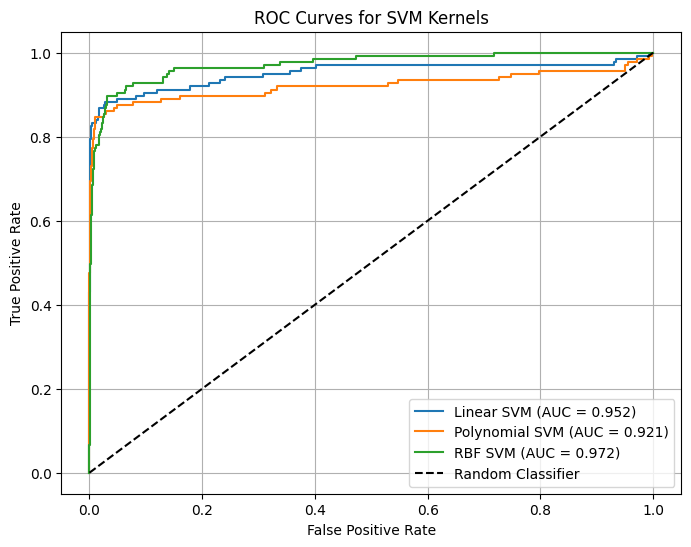

In [12]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Predict decision scores (probability-like values)
y_scoreL   = svcL_pipeline.decision_function(X_test)
y_scorePoly = svcPoly_pipeline.decision_function(X_test)
y_scoreRBF = svcRBF_pipeline.decision_function(X_test)

# Compute ROC curve and AUC
fprL, tprL, _ = roc_curve(y_test, y_scoreL)
fprPoly, tprPoly, _ = roc_curve(y_test, y_scorePoly)
fprRBF, tprRBF, _ = roc_curve(y_test, y_scoreRBF)

aucL   = roc_auc_score(y_test, y_scoreL)
aucPoly = roc_auc_score(y_test, y_scorePoly)
aucRBF = roc_auc_score(y_test, y_scoreRBF)

# Plot
plt.figure(figsize=(8,6))
plt.plot(fprL, tprL, label=f'Linear SVM (AUC = {aucL:.3f})')
plt.plot(fprPoly, tprPoly, label=f'Polynomial SVM (AUC = {aucPoly:.3f})')
plt.plot(fprRBF, tprRBF, label=f'RBF SVM (AUC = {aucRBF:.3f})')

plt.plot([0,1],[0,1],'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for SVM Kernels')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Explanation of ROC Curve Image

The ROC (Receiver Operating Characteristic) curve shows the trade-off between True Positive Rate (Recall) and False Positive Rate for the three SVM kernels. Each curve represents how well the model distinguishes between fraud and non-fraud across different thresholds. The diagonal dashed line is the performance of a random classifier (AUC = 0.5). A good model’s curve stays close to the top-left corner.

From the plot:

Linear SVM (AUC = 0.952) → Performs very well with a nearly linear boundary, showing that the data is somewhat separable in a linear space.

Polynomial SVM (AUC = 0.921) → Performs slightly worse, suggesting that adding polynomial interactions did not improve performance and may have introduced noise or overfitting.

RBF SVM (AUC = 0.972) → Performs the best, with the highest AUC score. The flexible non-linear boundary of the RBF kernel captures the complex patterns in the fraud dataset more effectively.

Conclusion: All kernels perform well (AUC > 0.9), but the RBF kernel provides the best separation between fraud and non-fraud. This makes it the most suitable for fraud detection, where decision boundaries are rarely linear.

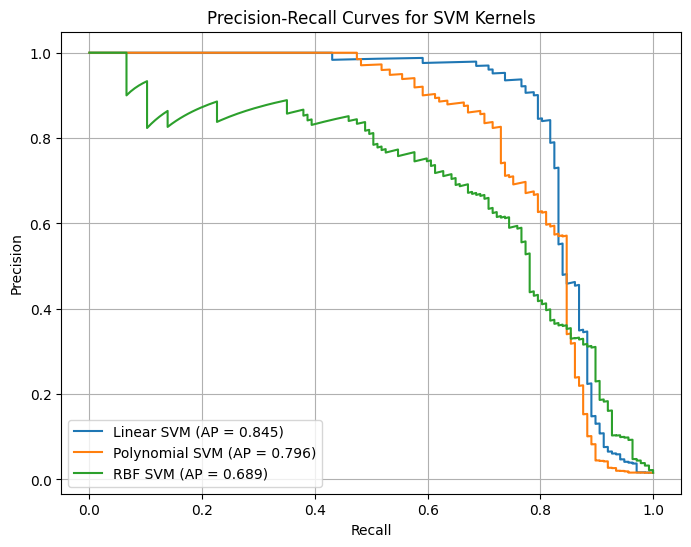

In [13]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute Precision-Recall values
precL, recL, _ = precision_recall_curve(y_test, y_scoreL)
precPoly, recPoly, _ = precision_recall_curve(y_test, y_scorePoly)
precRBF, recRBF, _ = precision_recall_curve(y_test, y_scoreRBF)

# Average Precision (AP) score is the area under the PR curve
apL   = average_precision_score(y_test, y_scoreL)
apPoly = average_precision_score(y_test, y_scorePoly)
apRBF = average_precision_score(y_test, y_scoreRBF)

# Plot
plt.figure(figsize=(8,6))
plt.plot(recL, precL, label=f'Linear SVM (AP = {apL:.3f})')
plt.plot(recPoly, precPoly, label=f'Polynomial SVM (AP = {apPoly:.3f})')
plt.plot(recRBF, precRBF, label=f'RBF SVM (AP = {apRBF:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for SVM Kernels')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

Explanation of Precision–Recall Curve Image

The Precision–Recall (PR) curve shows the trade-off between precision (how many predicted frauds are actually fraud) and recall (how many fraud cases the model successfully detects). This evaluation is particularly important in fraud detection, where the dataset is highly imbalanced.

From the plot:

Linear SVM (AP = 0.845) → Achieves the best balance between precision and recall. It maintains high precision across a wide recall range, meaning it is effective at identifying fraud without producing too many false alarms.

Polynomial SVM (AP = 0.796) → Performs slightly worse than the linear kernel, showing that polynomial interactions didn’t improve the model much in this case.

RBF SVM (AP = 0.689) → Despite being the best in ROC analysis, the RBF kernel underperforms in the PR curve. It struggles to maintain precision as recall increases, leading to more false positives when trying to detect all fraud cases.

Conclusion: While the ROC curve suggested that the RBF kernel was best overall, the Precision–Recall curve reveals that the linear kernel actually performs better for this imbalanced fraud dataset. This highlights why both metrics should be considered in fraud detection — ROC can look good even when precision is low, whereas PR focuses directly on the fraud detection challenge.

Overall Conclusion

ROC analysis suggested that the RBF kernel is strongest (highest AUC).

PR analysis, which is more reliable for imbalanced datasets, showed that the linear kernel is actually better because it maintains higher precision while detecting fraud cases.

This demonstrates why multiple evaluation metrics are important: while ROC can look optimistic in imbalanced problems, PR curves give a clearer view of actual fraud detection performance.

While the RBF kernel looks best in ROC analysis, the linear kernel is more effective for fraud detection because it balances precision and recall better, reducing false positives.